Mask R-CNN object detection and segmentation with COCO evaluation in PyTorch.

In [ ]:
!pip install torch torchvision pycocotools matplotlib opencv-python Pillow requests

In [1]:
import os
import json
import io
import torch
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms as T
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


In [2]:
def download_and_extract_zip(url, extract_to):
    filename = url.split("/")[-1]
    zip_path = os.path.join(extract_to, filename)

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    if not os.path.exists(zip_path):
        print(f"📥 Downloading {filename} ...")
        r = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(r.content)
        print(f"✅ Downloaded {filename}")
    else:
        print(f"✅ {filename} already exists.")

    print(f"📦 Extracting {filename} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted to {extract_to}")

# Paths
save_dir = "coco"
download_and_extract_zip("http://images.cocodataset.org/annotations/annotations_trainval2017.zip", save_dir)
download_and_extract_zip("http://images.cocodataset.org/zips/val2017.zip", save_dir)


📥 Downloading annotations_trainval2017.zip ...
✅ Downloaded annotations_trainval2017.zip
📦 Extracting annotations_trainval2017.zip ...
✅ Extracted to coco
📥 Downloading val2017.zip ...
✅ Downloaded val2017.zip
📦 Extracting val2017.zip ...
✅ Extracted to coco


In [3]:
def find_val2017_dir(base_dir='coco'):
    expected = os.path.join(base_dir, 'val2017')
    nested = os.path.join(expected, 'val2017')

    if os.path.exists(expected) and len(os.listdir(expected)) > 0:
        return expected
    elif os.path.exists(nested) and len(os.listdir(nested)) > 0:
        return nested
    else:
        raise FileNotFoundError("val2017 images not found.")

val_image_dir = find_val2017_dir()
print("Using val2017 images from:", val_image_dir)


Using val2017 images from: coco/val2017


In [4]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 75.0MB/s]


Using device: cuda


In [5]:
ann_file = os.path.join(save_dir, 'annotations', 'instances_val2017.json')
coco = COCO(ann_file)
transform = T.ToTensor()


loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [6]:
results = []
img_ids = coco.getImgIds()[:5]  # test on 5 images

for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(val_image_dir, img_info['file_name'])

    if not os.path.exists(img_path):
        print("Skipping missing:", img_path)
        continue

    image = Image.open(img_path).convert("RGB").resize((800, 600))  # optional resize
    image_tensor = transform(image).to(device)

    with torch.no_grad():
        prediction = model([image_tensor])[0]

    for i in range(len(prediction['scores'])):
        score = prediction['scores'][i].item()
        if score < 0.05:
            continue

        box = prediction['boxes'][i].cpu().numpy()
        bbox_coco = [float(box[0]), float(box[1]), float(box[2]-box[0]), float(box[3]-box[1])]

        results.append({
            "image_id": img_id,
            "category_id": int(prediction['labels'][i].item()),
            "bbox": bbox_coco,
            "score": score
        })


In [7]:
with open("coco_results.json", "w") as f:
    json.dump(results, f)
print("✅ Results saved to coco_results.json")


✅ Results saved to coco_results.json


In [8]:
coco_dt = coco.loadRes("coco_results.json")
coco_eval = COCOeval(coco, coco_dt, iouType='bbox')

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.63s).
Accumulating evaluation results...
DONE (t=1.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

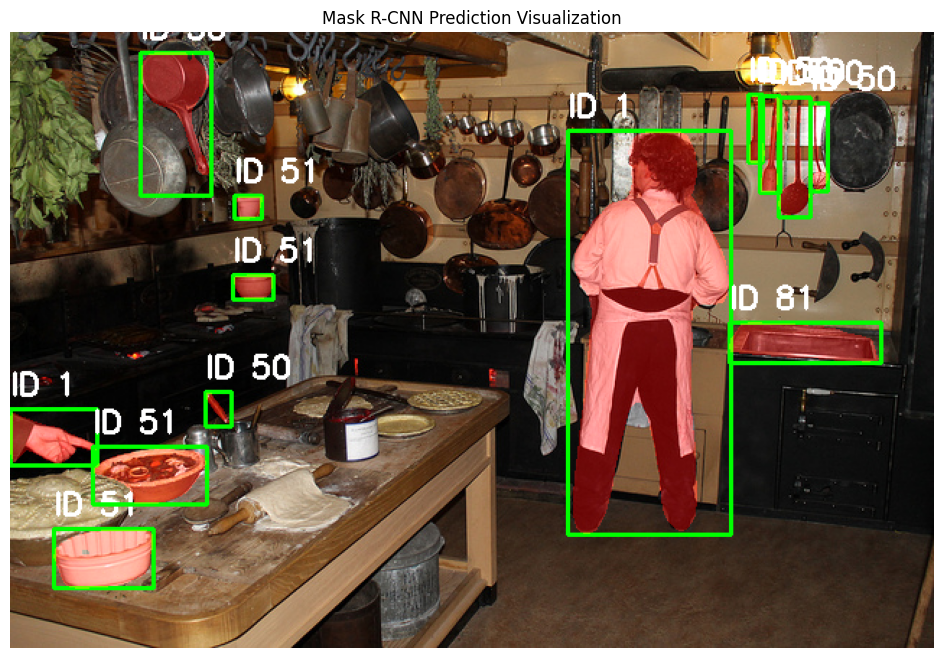

In [9]:
import cv2

img_info = coco.loadImgs(img_ids[0])[0]
img_path = os.path.join(val_image_dir, img_info['file_name'])
image = Image.open(img_path).convert("RGB")
image_tensor = transform(image).to(device)

with torch.no_grad():
    prediction = model([image_tensor])[0]

image_np = np.array(image).copy()

for i in range(len(prediction["boxes"])):
    score = prediction["scores"][i].item()
    if score > 0.7:
        box = prediction["boxes"][i].cpu().numpy().astype(int)
        label = prediction["labels"][i].item()
        mask = prediction["masks"][i, 0].cpu().numpy()

        cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        cv2.putText(image_np, f"ID {label}", (box[0], box[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        red_mask = np.zeros_like(image_np)
        red_mask[mask > 0.5] = [255, 0, 0]
        image_np = cv2.addWeighted(image_np, 1, red_mask, 0.4, 0)

plt.figure(figsize=(12, 8))
plt.imshow(image_np)
plt.axis("off")
plt.title("Mask R-CNN Prediction Visualization")
plt.show()
